<a href="https://colab.research.google.com/github/nrnazifi/FH_Campus_Web_Einzelprojekt/blob/master/Melbourne_On_street_Car_Parking_Sensor_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initalizing and Downloading Dataseries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
#!/usr/bin/env python

# make sure to install these packages before running:
# pip install pandas
# pip install sodapy
# pip install statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

!pip install sodapy
from sodapy import Socrata

from google.colab import data_table

import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.melbourne.vic.gov.au", None, None, None, None, None, timeout=60*5)

# QUERY - show count of events per deviceid
query1="""
select
  area, streetid, streetname, deviceid, count(deviceid) as events
where
  area='Docklands' and streetname='BOURKE STREET'
group by
  area, streetid, streetname, deviceid
order by count(deviceid) desc
"""

# QUERY - '2017-01-01T00:00:00.000' + datetime_diff(to_fixed_timestamp('2017-12-13T00:24:53Z'), to_fixed_timestamp('2017-12-13T00:24:55Z'), 'UTC', 'seconds') * 10 MINUTE AS start_time
query="""
select
    deviceid, arrivaltime, departuretime, durationseconds, area, streetid, streetname, vehicle_present
where
  streetname='QUEEN STREET' and vehicle_present = 'True'
order by arrivaltime
limit 10000000
"""
results = client.get("u9sa-j86i", query=query)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)
results_df

,deviceid,arrivaltime,departuretime,durationseconds,area,streetid,streetname,vehicle_present
0,19449,2017-01-01T00:00:00.000,2017-01-01T01:39:50.000,5990,Titles,1171,QUEEN STREET,True
1,19487,2017-01-01T00:00:00.000,2017-01-01T00:40:17.000,2417,Victoria Market,1171,QUEEN STREET,True
2,18122,2017-01-01T00:00:00.000,2017-01-01T01:39:48.000,5988,Titles,1171,QUEEN STREET,True
3,18077,2017-01-01T00:00:00.000,2017-01-01T00:50:52.000,3052,McKillop,1171,QUEEN STREET,True
4,18029,2017-01-01T00:00:00.000,2017-01-01T00:58:47.000,3527,Titles,1171,QUEEN STREET,True
...,...,...,...,...,...,...,...,...
1240544,18016,2017-12-31T23:21:46.000,2017-12-31T23:58:06.000,2180,Hardware,1171,QUEEN STREET,True
1240545,18135,2017-12-31T23:23:43.000,2017-12-31T23:37:01.000,798,Titles,1171,QUEEN STREET,True
1240546,18015,2017-12-31T23:24:58.000,2017-12-31T23:56:59.000,1921,Hardware,1171,QUEEN STREET,True
1240547,18018,2017-12-31T23:31:21.000,2017-12-31T23:40:47.000,566,Hardware,1171,QUEEN STREET,True


# Data Preprocessing 
(Prepare the Data)

In [10]:
# copy data to protect from main data
df_raw = results_df.copy() 

# display data types
df_raw.dtypes

deviceid           object
arrivaltime        object
departuretime      object
durationseconds    object
area               object
streetid           object
streetname         object
vehicle_present    object
dtype: object

In [ ]:
df_raw.head(10)

,deviceid,arrivaltime,departuretime,durationseconds,area,streetid,streetname,vehicle_present
0,19449,2017-01-01T00:00:00.000,2017-01-01T01:39:50.000,5990,Titles,1171,QUEEN STREET,True
1,19487,2017-01-01T00:00:00.000,2017-01-01T00:40:17.000,2417,Victoria Market,1171,QUEEN STREET,True
2,18122,2017-01-01T00:00:00.000,2017-01-01T01:39:48.000,5988,Titles,1171,QUEEN STREET,True
3,18077,2017-01-01T00:00:00.000,2017-01-01T00:50:52.000,3052,McKillop,1171,QUEEN STREET,True
4,18029,2017-01-01T00:00:00.000,2017-01-01T00:58:47.000,3527,Titles,1171,QUEEN STREET,True
5,19465,2017-01-01T00:00:00.000,2017-01-01T03:27:00.000,12420,Victoria Market,1171,QUEEN STREET,True
6,18074,2017-01-01T00:00:00.000,2017-01-01T00:24:11.000,1451,McKillop,1171,QUEEN STREET,True
7,18099,2017-01-01T00:00:00.000,2017-01-01T00:36:21.000,2181,Hardware,1171,QUEEN STREET,True
8,18087,2017-01-01T00:00:00.000,2017-01-01T00:46:46.000,2806,McKillop,1171,QUEEN STREET,True
9,18089,2017-01-01T00:00:00.000,2017-01-01T00:48:53.000,2933,Hardware,1171,QUEEN STREET,True


Cleaning

In [ ]:
df_clean = df_raw.copy()

#change some types
df_clean['arrivaltime'] = pd.to_datetime(df_clean.arrivaltime).astype('datetime64')
df_clean['departuretime'] = pd.to_datetime(df_clean.departuretime).astype('datetime64')
df_clean['durationseconds'] = pd.to_numeric(df_clean.durationseconds).astype('int')
df_clean['vehicle_present'] = df_clean.vehicle_present.astype('bool')
#add some new columns
df_clean['date'] = df_clean.arrivaltime.dt.date
df_clean['dayofweek'] = df_clean.arrivaltime.dt.dayofweek
df_clean['time'] = df_clean.arrivaltime.dt.time
df_clean['arrival_halfhour'] = df_clean.arrivaltime.dt.round('30min')
df_clean['departure_halfhour'] = df_clean.departuretime.dt.round('30min')

#remove records with durationseconds = 0
#TODO instead of removing we can use Mean for <0
pre_len = len(df_clean)
df_clean = df_clean[df_clean.durationseconds > 0]
post_len = len(df_clean)
print('dropped_len(0): {}'.format(pre_len - post_len))

#remove duplicated records
pre_len = len(df_clean)
df_clean = df_clean.drop_duplicates()
post_len = len(df_clean)
print('dropped_len(dup): {}'.format(pre_len - post_len))

df_clean.head(10)

dropped_len(0): 23
dropped_len(dup): 15


,deviceid,arrivaltime,departuretime,durationseconds,area,streetid,streetname,vehicle_present,date,dayofweek,time,arrival_halfhour,departure_halfhour
0,19449,2017-01-01,2017-01-01 01:39:50,5990,Titles,1171,QUEEN STREET,True,2017-01-01,6,00:00:00,2017-01-01,2017-01-01 01:30:00
1,19487,2017-01-01,2017-01-01 00:40:17,2417,Victoria Market,1171,QUEEN STREET,True,2017-01-01,6,00:00:00,2017-01-01,2017-01-01 00:30:00
2,18122,2017-01-01,2017-01-01 01:39:48,5988,Titles,1171,QUEEN STREET,True,2017-01-01,6,00:00:00,2017-01-01,2017-01-01 01:30:00
3,18077,2017-01-01,2017-01-01 00:50:52,3052,McKillop,1171,QUEEN STREET,True,2017-01-01,6,00:00:00,2017-01-01,2017-01-01 01:00:00
4,18029,2017-01-01,2017-01-01 00:58:47,3527,Titles,1171,QUEEN STREET,True,2017-01-01,6,00:00:00,2017-01-01,2017-01-01 01:00:00
5,19465,2017-01-01,2017-01-01 03:27:00,12420,Victoria Market,1171,QUEEN STREET,True,2017-01-01,6,00:00:00,2017-01-01,2017-01-01 03:30:00
6,18074,2017-01-01,2017-01-01 00:24:11,1451,McKillop,1171,QUEEN STREET,True,2017-01-01,6,00:00:00,2017-01-01,2017-01-01 00:30:00
7,18099,2017-01-01,2017-01-01 00:36:21,2181,Hardware,1171,QUEEN STREET,True,2017-01-01,6,00:00:00,2017-01-01,2017-01-01 00:30:00
8,18087,2017-01-01,2017-01-01 00:46:46,2806,McKillop,1171,QUEEN STREET,True,2017-01-01,6,00:00:00,2017-01-01,2017-01-01 01:00:00
9,18089,2017-01-01,2017-01-01 00:48:53,2933,Hardware,1171,QUEEN STREET,True,2017-01-01,6,00:00:00,2017-01-01,2017-01-01 01:00:00


Find number of occupied devices at each30 min

In [12]:
#find number of devices in the Queen street
Capacity = df_clean.copy().deviceid.nunique()
print('Capacity: {}'.format(Capacity))

dict_occupancy = {}

#a loop to find how many spots are occupeid at each 30 min
startTime = datetime(2017, 1, 1, 0, 0, 0)
endTime = datetime(2018, 1, 1, 0, 0, 0)
while startTime < endTime:
  mask = (df_clean.arrivaltime <= startTime) & (startTime < df_clean.departuretime)
  length = len(df_clean.loc[mask])
  dict_occupancy[startTime] = length
  nextTimeStep = startTime +  timedelta(minutes=30)
  startTime = nextTimeStep

print(dict(list(dict_occupancy.items())[0:10]))
df_occupancy = pd.DataFrame(list(dict_occupancy.items()), columns=['datetime', 'occupiedSpots'])

print('Length: {}'.format(len(df_occupancy)))
df_occupancy.head(10)

Capacity: 204
{datetime.datetime(2017, 1, 1, 0, 0): 171, datetime.datetime(2017, 1, 1, 0, 30): 145, datetime.datetime(2017, 1, 1, 1, 0): 103, datetime.datetime(2017, 1, 1, 1, 30): 80, datetime.datetime(2017, 1, 1, 2, 0): 68, datetime.datetime(2017, 1, 1, 2, 30): 69, datetime.datetime(2017, 1, 1, 3, 0): 65, datetime.datetime(2017, 1, 1, 3, 30): 50, datetime.datetime(2017, 1, 1, 4, 0): 57, datetime.datetime(2017, 1, 1, 4, 30): 54}
Length: 17520


,datetime,occupiedSpots
0,2017-01-01 00:00:00,171
1,2017-01-01 00:30:00,145
2,2017-01-01 01:00:00,103
3,2017-01-01 01:30:00,80
4,2017-01-01 02:00:00,68
5,2017-01-01 02:30:00,69
6,2017-01-01 03:00:00,65
7,2017-01-01 03:30:00,50
8,2017-01-01 04:00:00,57
9,2017-01-01 04:30:00,54


In [14]:
# add again some columns 
df_occupancy['Capacity'] = Capacity
df_occupancy['percentOccupied'] = df_occupancy.occupiedSpots / Capacity
df_occupancy['date'] = df_occupancy.datetime.dt.date
df_occupancy['dayofweek'] = df_occupancy.datetime.dt.dayofweek
df_occupancy['time'] = df_occupancy.datetime.dt.time
df_occupancy.head(10)

,datetime,occupiedSpots,Capacity,percentOccupied,date,dayofweek,time
0,2017-01-01 00:00:00,171,204,0.838235,2017-01-01,6,00:00:00
1,2017-01-01 00:30:00,145,204,0.710784,2017-01-01,6,00:30:00
2,2017-01-01 01:00:00,103,204,0.504902,2017-01-01,6,01:00:00
3,2017-01-01 01:30:00,80,204,0.392157,2017-01-01,6,01:30:00
4,2017-01-01 02:00:00,68,204,0.333333,2017-01-01,6,02:00:00
5,2017-01-01 02:30:00,69,204,0.338235,2017-01-01,6,02:30:00
6,2017-01-01 03:00:00,65,204,0.318627,2017-01-01,6,03:00:00
7,2017-01-01 03:30:00,50,204,0.245098,2017-01-01,6,03:30:00
8,2017-01-01 04:00:00,57,204,0.279412,2017-01-01,6,04:00:00
9,2017-01-01 04:30:00,54,204,0.264706,2017-01-01,6,04:30:00


In [15]:
# We can check along all of the observations by seeing whether PercentOccupied is between 0% and 100%.
print('Minimum Percent Occupied: {:.2%}'.format(df_occupancy.percentOccupied.min()))
print('Maximum Percent Occupied: {:.2%}'.format(df_occupancy.percentOccupied.max()))

Minimum Percent Occupied: 0.00%
Maximum Percent Occupied: 93.63%


Visulatiation Data

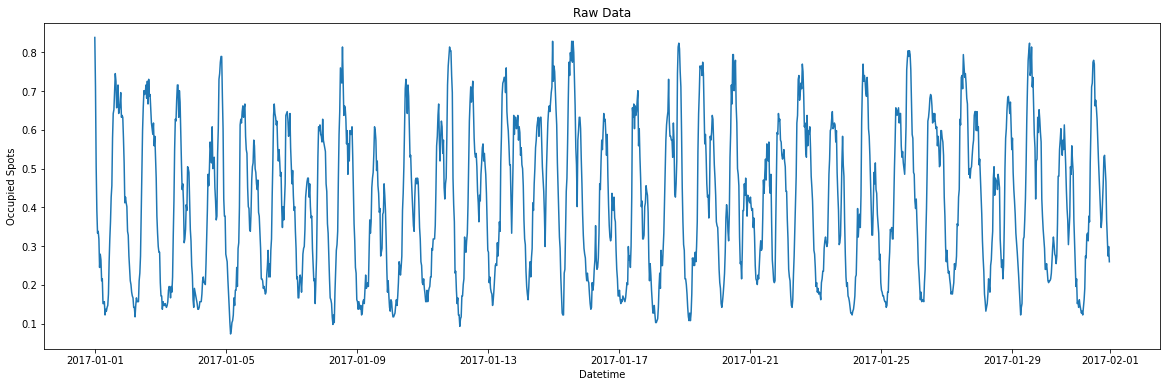

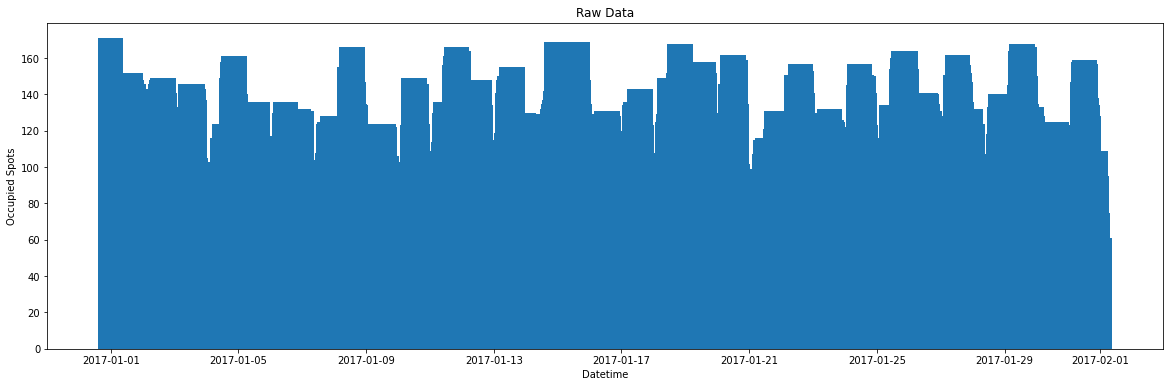

In [64]:
df = df_occupancy[df_occupancy.datetime < datetime(2017, 2, 1, 0, 0, 0)]

plt.figure(figsize=(20,6))
plt.plot(df.datetime, df.percentOccupied)
plt.plot()
plt.xlabel("Datetime")
plt.ylabel("Occupied Spots")
plt.title("Raw Data")
plt.show()

plt.figure(figsize=(20,6))
plt.bar(df.datetime, df.occupiedSpots)
plt.plot()

plt.xlabel("Datetime")
plt.ylabel("Occupied Spots")
plt.title("Raw Data")
plt.show()

In [19]:
#Unnecessary
df_agg_dthh = df_occupancy.groupby('datetime').agg({'occupiedSpots':['sum','count'], 'Capacity':['sum','count']})
df_agg_dthh['percentOccupied'] = df_agg_dthh.occupiedSpots['sum'] / df_agg_dthh.Capacity['sum']
df_agg_dthh.drop(columns=['occupiedSpots', 'Capacity'], inplace=True)
df_agg_dthh.head()

,percentOccupied
,
datetime,
2017-01-01 00:00:00,0.838235
2017-01-01 00:30:00,0.710784
2017-01-01 01:00:00,0.504902
2017-01-01 01:30:00,0.392157
2017-01-01 02:00:00,0.333333


It is a good idea to fix the random number seed to ensure our results are reproducible.

In [20]:
# fix random seed for reproducibility
np.random.seed(7)

# Data Division

we separate the data into training, validation, and testing subsets to prevent the model from overfitting and to evaluate the model effectively.

In [40]:
# Train-Test Split
# Sklearn built in split for time series

from sklearn.model_selection import TimeSeriesSplit

# NAVID: I commented codes from Omid
# tscv = TimeSeriesSplit(n_splits=5)
# print(tscv)

# data_use = df_agg_dthh.reset_index()['percentOccupied']

# for train_index, test_index in tscv.split(data_use):
#   train = data_use[train_index]
#   test = data_use[test_index]

df_use = df_occupancy.loc[:, df_occupancy.columns=='percentOccupied']
dataset = df_use.values
dataset = dataset.astype('float32')
dataset

array([[0.8382353 ],
       [0.7107843 ],
       [0.50490195],
       ...,
       [0.08333334],
       [0.04901961],
       [0.0245098 ]], dtype=float32)

We can check that the time split worked properly by making sure that the end of the training data lines up with the beginning of the test data.

In [ ]:
# train.index = df_agg_dthh.index[:len(train)]
# train.tail()

In [ ]:
# test.index = df_agg_dthh.index[len(train):]
# test.head()

since the sequence of values with time series data is important, we used a simple method to split the ordered dataset into train, validation and test datasets (instead of train_test_split() or train_valid_test_split()). 

In [72]:
# split into train, validation and test sets
# 80% Train, 10% Validation, 10% Test
train_size = int(len(dataset) * 0.8)
valid_size = int(len(dataset) * 0.10)
test_size  = len(dataset) - (train_size + valid_size)
train = dataset[0:train_size,:]
valid = dataset[train_size:(train_size + valid_size),:]
test  = dataset[(train_size + valid_size):len(dataset),:]

print("train_size, test_valid_size: {}, {}, {}".format(train_size, valid_size, test_size))
print("len(train), len(valid), len(test): {}, {}, {}".format(len(train), len(valid), len(test)))

train_size, test_valid_size: 14016, 1752, 1752
len(train), len(valid), len(test): 14016, 1752, 1752


# Models



## Autoregressive Model

In [ ]:
#from statsmodels.tsa.ar_model import AutoReg

# Define and fit ARIMA model
#autoreg_model = AutoReg(train, order=(18, 1, 0))
#results_AutoReg = autoreg_model.fit(disp=-1)

## LSTM

In [41]:

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [73]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(test, look_back)
print("Train-X before reshape: \n{}\n\n".format(trainX))

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
testX  = np.reshape(testX,  (testX.shape[0], 1, testX.shape[1]))

print("Train data for X: \n{} \n\nTrain data for Y: \n{}".format(trainX, trainY))

Train-X before reshape: 
[[0.8382353 ]
 [0.7107843 ]
 [0.50490195]
 ...
 [0.50980395]
 [0.45588234]
 [0.44607842]]


Train data for X: 
[[[0.8382353 ]]

 [[0.7107843 ]]

 [[0.50490195]]

 ...

 [[0.50980395]]

 [[0.45588234]]

 [[0.44607842]]] 

Train data for Y: 
[0.7107843  0.50490195 0.39215687 ... 0.45588234 0.44607842 0.4019608 ]


In [74]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2, validation_data=(validX, validY))

Epoch 1/10
14014/14014 - 25s - loss: 0.0067 - val_loss: 0.0030 - 25s/epoch - 2ms/step
Epoch 2/10
14014/14014 - 23s - loss: 0.0031 - val_loss: 0.0027 - 23s/epoch - 2ms/step
Epoch 3/10
14014/14014 - 22s - loss: 0.0031 - val_loss: 0.0026 - 22s/epoch - 2ms/step
Epoch 4/10
14014/14014 - 22s - loss: 0.0031 - val_loss: 0.0028 - 22s/epoch - 2ms/step
Epoch 5/10
14014/14014 - 22s - loss: 0.0031 - val_loss: 0.0026 - 22s/epoch - 2ms/step
Epoch 6/10
14014/14014 - 21s - loss: 0.0031 - val_loss: 0.0026 - 21s/epoch - 2ms/step
Epoch 7/10
14014/14014 - 22s - loss: 0.0031 - val_loss: 0.0026 - 22s/epoch - 2ms/step
Epoch 8/10
14014/14014 - 21s - loss: 0.0031 - val_loss: 0.0026 - 21s/epoch - 2ms/step
Epoch 9/10
14014/14014 - 21s - loss: 0.0031 - val_loss: 0.0026 - 21s/epoch - 2ms/step
Epoch 10/10
14014/14014 - 21s - loss: 0.0031 - val_loss: 0.0026 - 21s/epoch - 2ms/step


In [76]:
# make predictions
trainPredict = model.predict(trainX) #TODO: do we need that?
validPredict = model.predict(validX) #TODO: do we need that?
testPredict = model.predict(testX)
# invert predictions #TODO: I think we have do it manually
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = scaler.inverse_transform([trainY])
# testPredict = scaler.inverse_transform(testPredict)
# testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
validScore = math.sqrt(mean_squared_error(validY, validPredict[:,0]))
print('Valid Score: %.2f RMSE' % (validScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.06 RMSE
Valid Score: 0.05 RMSE
Test Score: 0.05 RMSE


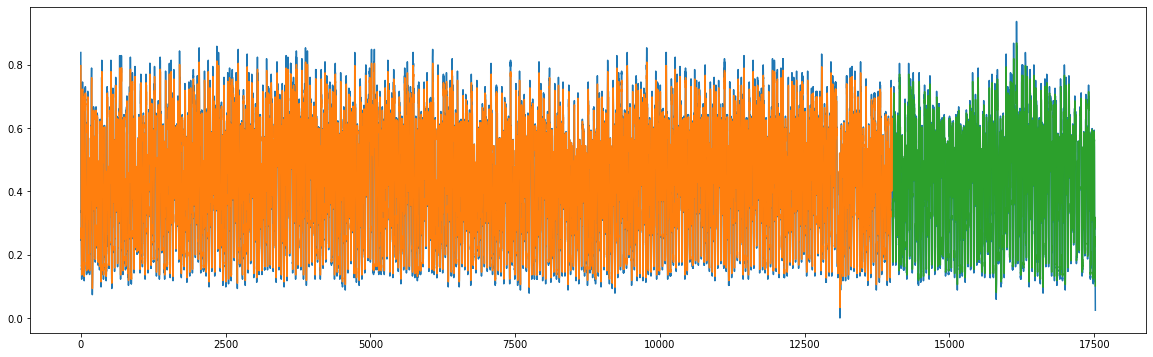

In [60]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
validPredictPlot = np.empty_like(dataset)
validPredictPlot[:, :] = np.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = validPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,6))
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()